In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
from pathlib import Path
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
from typing import Any, Callable, Optional
from PIL import Image
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
import copy
import csv
import os
import time
from tqdm import tqdm
import click
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils import data

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    model.train()
    return model

In [ ]:
class PianorollDataset(VisionDataset):

    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None):

        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder


        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")
            
        if not fraction: #if fraction == None：
            self.image_names = sorted(image_folder_path.glob("*"))
            self.mask_names = sorted(mask_folder_path.glob("*"))
        else:
            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*"))) #attributes (self.image_list)
            self.mask_list = np.array(sorted(mask_folder_path.glob("*"))) #attributes (self.mask_list)
            if seed != None:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices) #Modify a sequence in-place by shuffling its contents. This function only shuffles the array along the first axis of a multi-dimensional array. The order of sub-arrays is changed but their contents remains the same.
                #arr = np.arange(10) -> np.random.shuffle(arr) --> [1 7 5 2 9 4 3 6 0 8] 
                self.image_list = self.image_list[indices]
                self.mask_list = self.mask_list[indices]
                #right now only accounts for training seT?
                if subset == "Training":
                    self.image_names = self.image_list[:int(np.ceil(len(self.image_list) * (1 - self.fraction)))] #the training set
                    self.mask_names = self.mask_list[:int(np.ceil(len(self.mask_list) * (1 - self.fraction)))]  #the training set
                elif subset == "Validation":
                    self.image_names = self.image_list[int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                    self.mask_names = self.mask_list[int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]


    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):
        #return one item on the index, for given index, we return the item at that index
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        with open(image_path, "rb") as image_file, open(mask_path, "rb") as mask_file:
            image = Image.open(image_file)
            image = image.convert("RGB")
            mask = Image.open(mask_file)
            mask = mask.convert("L")
            sample = {"image": image, "mask":mask} #dictionary 
            if self.transforms != None: #if we want to use a specific transform
                sample['image'] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample

In [ ]:
def dataloader(data_dir: str,
                                 image_folder: str = 'resized_input',
                                 mask_folder: str = 'resized_target',
                                 fraction: float = 0.2,
                                 batch_size: int = 4):
    """Create train and test dataloader from a single directory containing
    the image and mask folders.
    Args:
        data_dir (str): Data directory path or root
        image_folder (str, optional): Image folder name. Defaults to 'Images'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Masks'.
        fraction (float, optional): Fraction of Test set. Defaults to 0.2.
        batch_size (int, optional): Dataloader batch size. Defaults to 4.
    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """
    data_transforms = transforms.Compose([transforms.ToTensor()])
    #transforms.ToTensor(): This just converts your input image to PyTorch tensor.
    #torchvision.transforms.Compose(transforms)
    #Composes several transforms together. This transform does not support torchscript. Please, see the note below.
    '''
    Most transformations accept both PIL images and tensor images, although some transformations are PIL-only and some are tensor-only. 
    The Conversion Transforms may be used to convert to and from PIL images. The transformations that accept tensor images also accept 
    batches of tensor images. A Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image 
    height and width. A batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch.
    '''

    image_datasets = {
        x: PianorollDataset(data_dir,
                               image_folder=image_folder,
                               mask_folder=mask_folder,
                               seed=100,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms)
        for x in ['Training', 'Validation']
    }

    #The DataLoader class is designed so that it can be iterated using the enumerate() function, which returns a tuple with the current batch zero-based index value, and the actual batch of data
    #read the documentation on the DataLoader class: https://pytorch.org/docs/stable/data.html 
    #we implement a map-style dataset
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8)
        for x in ['Training', 'Validation']
    }
    return dataloaders

In [ ]:
def get_model_name(model_name, batch_size, learning_rate, epoch):
    '''
    Generate a name for the model consisting of hyperparameter values

    Args:
         config: Configuration object containing the hyperparameters
    Returns: 
        path: A string with the hyperparameter name and value concatenated
    '''
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model_name, batch_size, learning_rate, epoch)

    return path

In [ ]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs, batch_size, learning_rate):
    torch.manual_seed(1000)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    start_time = time.time()

    #if gpu is available, use gpu
    state = "cpu"
    if torch.cuda.is_available():
        state = "cuda"
    
    device = torch.device(state)
    model.to(device)
    fieldnames = ['Epoch', 'Training_loss', 'Validation_loss'] + \
        [f'Training_{m}' for m in metrics.keys()] + \
        [f'Validation_{m}' for m in metrics.keys()] #

    #fieldnames = ['Epoch','Training_loss','Validation_loss','Training_f1_score','Training_auroc','Validation_f1_score','Validation_auroc']
    with open(os.path.join(bpath, 'results_log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 20)
        batchsummary = {a: [0] for a in fieldnames}

        i = 0
        total_loss = 0.0
        for phase in ['Training', 'Validation']:
            if phase == "Training":
                model.train()
            else:
                model.eval()
            
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    total_loss += loss.item()
                    i += 1
                    
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))
                    
                    if phase == "Training":
                        loss.backward()
                        optimizer.step()
                        

            batchsummary['Epoch'] = epoch
            epoch_loss = total_loss/(i+1) 
            batchsummary[f'{phase}_loss'] = epoch_loss
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'result_log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            if phase == 'Validation' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'Validation':
                model_path = get_model_name("Baseline",batch_size,learning_rate, epoch)
                torch.save(model.state_dict(), "gdrive/My Drive/APS360/Project/weights" + "/" + model_path)
        
    print("Finished Training")
    end_time = time.time()
    time_elapsed = start_time - end_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    return model

In [ ]:
def main(data_directory, output_directory, epochs, batch_size, learning_rate = 1e-4):
    # Create the deeplabv3 resnet101 model which is pretrained on a subset
    model = createDeepLabv3()
    model.train()
    data_directory = Path(data_directory)
    # Create the output directory if not present
    output_directory = Path(output_directory)
    if not output_directory.exists():
        output_directory.mkdir()
    
    #CREATE OWN WEIGHT PATH
    weights_path = "gdrive/My Drive/Project/weights"
    weights_path = Path(weights_path)
    if not weights_path.exists():
        weights_path.mkdir()

    # Specify the loss function
    criterion = torch.nn.MSELoss(reduction='mean')
    # Specify the optimizer with a lower learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Specify the evaluation metrics
    metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

    # Create the dataloader
    dataloaders = dataloader(
        data_directory, batch_size=batch_size)
    _ = train_model(model,
                    criterion,
                    dataloaders,
                    optimizer,
                    bpath=output_directory,
                    metrics=metrics,
                    num_epochs=epochs,
                batch_size = batch_size,
                learning_rate = learning_rate)

    # Save the trained model
    torch.save(model, output_directory / 'weights.pt')

In [ ]:
main("gdrive/My Drive/Project/JSB_Finale","gdrive/My Drive/Project/results",epochs = 30,batch_size = 4, learning_rate = 1e-4)
'''
data_directory is the path to folder containing input Images 
(ex: gdrive/My Drive/Project/JSB_Finale)

output_directory is the path to output folder (containing training log)
'''

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/30
--------------------


  0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 61/61 [04:02<00:00,  3.97s/it]

Training Loss: 0.0371



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


Validation Loss: 0.0315
{'Epoch': 1, 'Training_loss': 0.03709254642167399, 'Validation_loss': 0.031512060101167895, 'Training_f1_score': 0.048680233927109656, 'Training_auroc': 0.6918785575917781, 'Validation_f1_score': 0.17423891008398942, 'Validation_auroc': 0.8273880016522533}
Epoch 2/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0148



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


Validation Loss: 0.0138
{'Epoch': 2, 'Training_loss': 0.014799670271214939, 'Validation_loss': 0.013773735188759672, 'Training_f1_score': 0.10368109894849659, 'Training_auroc': 0.8174664987868566, 'Validation_f1_score': 0.18239033952799588, 'Validation_auroc': 0.8433421395513399}
Epoch 3/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0120



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Loss: 0.0114
{'Epoch': 3, 'Training_loss': 0.012034913119409353, 'Validation_loss': 0.011420421606789414, 'Training_f1_score': 0.15552531980502002, 'Training_auroc': 0.8700876056239707, 'Validation_f1_score': 0.2368132731402443, 'Validation_auroc': 0.8954270277687034}
Epoch 4/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0109



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Validation Loss: 0.0105
{'Epoch': 4, 'Training_loss': 0.010865943100784094, 'Validation_loss': 0.010471381121673264, 'Training_f1_score': 0.18787506660585354, 'Training_auroc': 0.8969965949815497, 'Validation_f1_score': 0.2387118742715467, 'Validation_auroc': 0.8817812080297005}
Epoch 5/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0103



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Validation Loss: 0.0100
{'Epoch': 5, 'Training_loss': 0.010278564261933488, 'Validation_loss': 0.010017420374191342, 'Training_f1_score': 0.20795554876335434, 'Training_auroc': 0.914747973226011, 'Validation_f1_score': 0.24147528397257212, 'Validation_auroc': 0.8818714230116645}
Epoch 6/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0100



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Loss: 0.0103
{'Epoch': 6, 'Training_loss': 0.009962804052197644, 'Validation_loss': 0.010276592712706098, 'Training_f1_score': 0.21935559342722472, 'Training_auroc': 0.9223652381019041, 'Validation_f1_score': 0.14009986392369173, 'Validation_auroc': 0.8895550037000919}
Epoch 7/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:01<00:00,  3.95s/it]

Training Loss: 0.0097



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Validation Loss: 0.0096
{'Epoch': 7, 'Training_loss': 0.009733841296345476, 'Validation_loss': 0.009588187530589027, 'Training_f1_score': 0.22618908795988948, 'Training_auroc': 0.9276348546706957, 'Validation_f1_score': 0.24660803981663595, 'Validation_auroc': 0.9017144107872302}
Epoch 8/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0095



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Validation Loss: 0.0094
{'Epoch': 8, 'Training_loss': 0.009482156643043122, 'Validation_loss': 0.009374156707706742, 'Training_f1_score': 0.2342190231227113, 'Training_auroc': 0.9365666792721822, 'Validation_f1_score': 0.24580441957663565, 'Validation_auroc': 0.8981895827672616}
Epoch 9/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0094



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Loss: 0.0092
{'Epoch': 9, 'Training_loss': 0.009358969960181464, 'Validation_loss': 0.00921045490898765, 'Training_f1_score': 0.23901758978322848, 'Training_auroc': 0.9414757468957867, 'Validation_f1_score': 0.2421980800573401, 'Validation_auroc': 0.9084089586774637}
Epoch 10/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:01<00:00,  3.95s/it]

Training Loss: 0.0093



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Validation Loss: 0.0093
{'Epoch': 10, 'Training_loss': 0.00927455852469129, 'Validation_loss': 0.00927159879117822, 'Training_f1_score': 0.24188551312164427, 'Training_auroc': 0.9431904824108731, 'Validation_f1_score': 0.2439919517861347, 'Validation_auroc': 0.8870491410942921}
Epoch 11/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0092



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Validation Loss: 0.0091
{'Epoch': 11, 'Training_loss': 0.009168797953715247, 'Validation_loss': 0.00905734533444047, 'Training_f1_score': 0.24590850238739687, 'Training_auroc': 0.9465094154242354, 'Validation_f1_score': 0.24494649501771992, 'Validation_auroc': 0.9121820695167593}
Epoch 12/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:01<00:00,  3.96s/it]

Training Loss: 0.0091



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Validation Loss: 0.0090
{'Epoch': 12, 'Training_loss': 0.009120394513311406, 'Validation_loss': 0.009018754103006078, 'Training_f1_score': 0.24828105871996456, 'Training_auroc': 0.9475921400874266, 'Validation_f1_score': 0.243373334757877, 'Validation_auroc': 0.9156730123852045}
Epoch 13/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0091



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Validation Loss: 0.0089
{'Epoch': 13, 'Training_loss': 0.00907245330933121, 'Validation_loss': 0.008934089436362952, 'Training_f1_score': 0.249716895744292, 'Training_auroc': 0.9486625087190343, 'Validation_f1_score': 0.24377335423085214, 'Validation_auroc': 0.9160614367892154}
Epoch 14/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:01<00:00,  3.96s/it]

Training Loss: 0.0090



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Validation Loss: 0.0089
{'Epoch': 14, 'Training_loss': 0.00902093494040591, 'Validation_loss': 0.008923158974935994, 'Training_f1_score': 0.25316030540348716, 'Training_auroc': 0.9506622269391786, 'Validation_f1_score': 0.2370399534601379, 'Validation_auroc': 0.9144415291873222}
Epoch 15/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:01<00:00,  3.95s/it]

Training Loss: 0.0090



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Loss: 0.0089
{'Epoch': 15, 'Training_loss': 0.008989528489990099, 'Validation_loss': 0.008914039416525226, 'Training_f1_score': 0.25454557905728686, 'Training_auroc': 0.9512389408715367, 'Validation_f1_score': 0.24989273325424996, 'Validation_auroc': 0.9093326291560556}
Epoch 16/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0089



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Validation Loss: 0.0088
{'Epoch': 16, 'Training_loss': 0.008945235381683996, 'Validation_loss': 0.008817992352235775, 'Training_f1_score': 0.257220288183784, 'Training_auroc': 0.9528001918060296, 'Validation_f1_score': 0.24632448420821335, 'Validation_auroc': 0.9166399274805496}
Epoch 17/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0089



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Validation Loss: 0.0088
{'Epoch': 17, 'Training_loss': 0.008915084151310785, 'Validation_loss': 0.008815651413244315, 'Training_f1_score': 0.25854865410535344, 'Training_auroc': 0.9532519027073234, 'Validation_f1_score': 0.24709561516219325, 'Validation_auroc': 0.914293224792003}
Epoch 18/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0089



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Validation Loss: 0.0088
{'Epoch': 18, 'Training_loss': 0.00889894628386584, 'Validation_loss': 0.008849531101683775, 'Training_f1_score': 0.2600713038586455, 'Training_auroc': 0.9537831771117553, 'Validation_f1_score': 0.2440022961968839, 'Validation_auroc': 0.9157891505914899}
Epoch 19/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0089



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Validation Loss: 0.0088
{'Epoch': 19, 'Training_loss': 0.008905053424138215, 'Validation_loss': 0.008813329088764314, 'Training_f1_score': 0.2593561180408377, 'Training_auroc': 0.9537120605018685, 'Validation_f1_score': 0.24901348955203662, 'Validation_auroc': 0.9119031427892124}
Epoch 20/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0089



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Loss: 0.0088
{'Epoch': 20, 'Training_loss': 0.00887757929552707, 'Validation_loss': 0.008775636153773237, 'Training_f1_score': 0.26135319429044807, 'Training_auroc': 0.9541186454236623, 'Validation_f1_score': 0.24789887772638905, 'Validation_auroc': 0.9166282858351903}
Epoch 21/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0089



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Validation Loss: 0.0088
{'Epoch': 21, 'Training_loss': 0.008899134185705935, 'Validation_loss': 0.008835452817714749, 'Training_f1_score': 0.259685485581932, 'Training_auroc': 0.9535337598094854, 'Validation_f1_score': 0.24645335339019359, 'Validation_auroc': 0.9145835475335667}
Epoch 22/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0089



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Validation Loss: 0.0088
{'Epoch': 22, 'Training_loss': 0.008850955013786592, 'Validation_loss': 0.008796606935226383, 'Training_f1_score': 0.2631481400112164, 'Training_auroc': 0.9550645270204137, 'Validation_f1_score': 0.24865308814975512, 'Validation_auroc': 0.9135849859474147}
Epoch 23/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Validation Loss: 0.0088
{'Epoch': 23, 'Training_loss': 0.008849984275237206, 'Validation_loss': 0.008830625301179213, 'Training_f1_score': 0.2638743611813622, 'Training_auroc': 0.9549661386736068, 'Validation_f1_score': 0.24945167857058995, 'Validation_auroc': 0.9160282500250025}
Epoch 24/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Validation Loss: 0.0088
{'Epoch': 24, 'Training_loss': 0.008830428333772768, 'Validation_loss': 0.008792175696446346, 'Training_f1_score': 0.2645169254812386, 'Training_auroc': 0.9551719032479413, 'Validation_f1_score': 0.24632258900264994, 'Validation_auroc': 0.9165684943938188}
Epoch 25/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Validation Loss: 0.0087
{'Epoch': 25, 'Training_loss': 0.008810124435131588, 'Validation_loss': 0.008736855911616331, 'Training_f1_score': 0.265706559965616, 'Training_auroc': 0.9560368331265184, 'Validation_f1_score': 0.24883279440486852, 'Validation_auroc': 0.9116355565261975}
Epoch 26/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Validation Loss: 0.0087
{'Epoch': 26, 'Training_loss': 0.008820017859820397, 'Validation_loss': 0.008746770974726249, 'Training_f1_score': 0.26559637353013404, 'Training_auroc': 0.9558821926243323, 'Validation_f1_score': 0.24697241385942778, 'Validation_auroc': 0.9163908406944712}
Epoch 27/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Validation Loss: 0.0087
{'Epoch': 27, 'Training_loss': 0.00880220940246457, 'Validation_loss': 0.008723362874335203, 'Training_f1_score': 0.26713637586025907, 'Training_auroc': 0.9564065044462444, 'Validation_f1_score': 0.2439542194924573, 'Validation_auroc': 0.9156895963077809}
Epoch 28/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Validation Loss: 0.0087
{'Epoch': 28, 'Training_loss': 0.008783828775067963, 'Validation_loss': 0.008716992317483975, 'Training_f1_score': 0.2687984778497913, 'Training_auroc': 0.9566098658105953, 'Validation_f1_score': 0.24617066502632762, 'Validation_auroc': 0.9162064276439665}
Epoch 29/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Loss: 0.0087
{'Epoch': 29, 'Training_loss': 0.008771865763851711, 'Validation_loss': 0.008694717475475792, 'Training_f1_score': 0.2696900651425487, 'Training_auroc': 0.9568397451647586, 'Validation_f1_score': 0.2418532464667324, 'Validation_auroc': 0.9157829709956952}
Epoch 30/30
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [04:00<00:00,  3.94s/it]

Training Loss: 0.0088



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Loss: 0.0087
{'Epoch': 30, 'Training_loss': 0.008767100884729335, 'Validation_loss': 0.008715464864881376, 'Training_f1_score': 0.26971181309764947, 'Training_auroc': 0.9569669526468357, 'Validation_f1_score': 0.2500934054879307, 'Validation_auroc': 0.9156877134860513}
Finished Training
Training complete in -127m 58s
Lowest Loss: 0.008695


In [ ]:
import matplotlib.pyplot as plt  
import pandas as pd
import os

def plot_curves(csv_filepath,y_train, y_val, x_unit = "Epoch", y_unit = "Loss"):
    '''
    Plot the loss curve for a model run, given the csv files 
    containing the training and validation loss.

    Args: 
    csv_filepath: The string path of the csv file containing training data
    '''
    df = pd.read_csv(csv_filepath)
    Train_loss_series = df[y_train]
    Val_loss_seires = df[y_val]
    Epoch_series = df[x_unit]

    #plot curves
    ax = plt.gca()
    df.plot(kind = 'line', x = x_unit, y = y_train,ax = ax)
    df.plot(kind = 'line', x = x_unit, y = y_val, ax = ax)
    plt.ylabel(y_unit)

    plt.show()

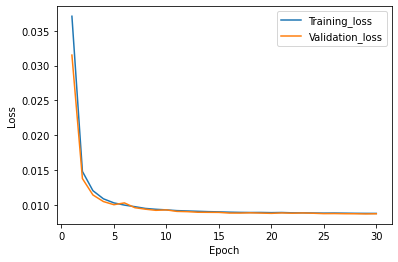

In [ ]:
plot_curves("gdrive/My Drive/Project/r/results_log.csv", "Training_loss", "Validation_loss")

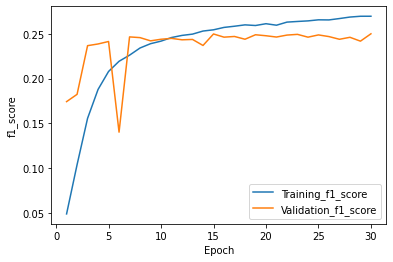

In [ ]:
plot_curves("gdrive/My Drive/Project/r/results_log.csv", "Training_f1_score", "Validation_f1_score", y_unit = "f1_score")

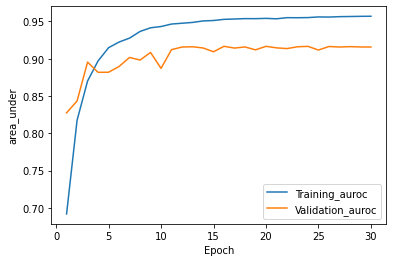

In [ ]:
plot_curves("gdrive/My Drive/APS360/Project/r/results_log.csv", "Training_auroc", "Validation_auroc", y_unit = "area_under")

In [ ]:
chosen_net = chosen_net = createDeepLabv3()
chosen_net.load_state_dict(torch.load("gdrive/My Drive/Project/weights/model_Baseline_bs4_lr0.0001_epoch29"))

#load model with best set of model weights
#(ex: "gdrive/My Drive/Project/weights/model_Baseline_bs4_lr0.0001_epoch29")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


<All keys matched successfully>

In [ ]:
def normalize(arr):
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))

In [ ]:
chosen_net.eval()
chosen_net.to('cpu')
chosen_net.requires_grad = False

In [ ]:
img = Image.open("gdrive/My Drive/APS360/Project/10_test/resized_input/sans.png").convert("RGB")

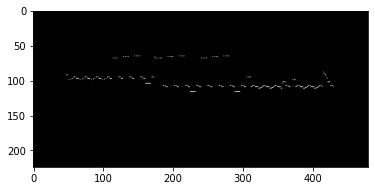

In [ ]:
plt.imshow(img)

In [ ]:
nimg = np.asarray(img)
h, w,_ = nimg.shape
preprocess = transforms.Compose([
    transforms.ToTensor()
    ])
outputs = chosen_net(torch.unsqueeze(preprocess(img), 0 ))["out"]
nout = normalize(outputs.detach().numpy()[0, 0, :,:])

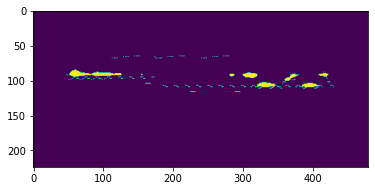

In [ ]:
threshold = 0.9
plt.imshow(nout>threshold)
plt.show()

In [ ]:
nout[nout>threshold] = 1 
nout[nout<=threshold] = 0
#clipping range
nout = nout + nimg[:,:,0]

In [ ]:
nout

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

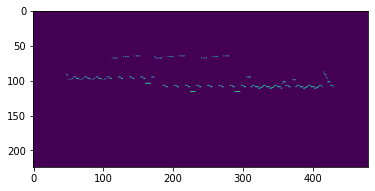

In [ ]:
plt.imshow(nout)

In [ ]:
output_path = "gdrive/My Drive/APS360/Project/model_output"
output_path = Path(output_path)
if not output_path.exists():
    output_path.mkdir()

Image.fromarray(255*nout).convert("RGB").save('gdrive/My Drive/Project/swag.png')
#confirm path to input image

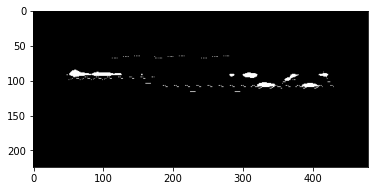

In [ ]:
plt.imshow(Image.fromarray(255*nout).convert("RGB"))

In [ ]:
def extract_output(model, input_path, output_path):
  model.eval()
  model.to('cpu')
  model.requires_grad = False
  img = Image.open(input_path).convert("RGB")
  nimg = np.asarray(img)
  preprocess = transforms.Compose([transforms.ToTensor()])
  outputs = model(torch.unsqueeze(preprocess(img), 0 ))["out"]
  nout = normalize(outputs.detach().numpy()[0, 0, :,:])
  threshold = 0.7
  nout[nout>threshold] = 1
  nout[nout<=threshold] = 0
  nout = nout + nimg[:,:,0]

  Image.fromarray(255*nout).convert("RGB").save(output_path)

In [ ]:
inn = "gdrive/My Drive/Project/10_test/resized_input"
out = "gdrive/My Drive/Project/10_test_out"

im_list = []
for image in os.listdir(inn):
  if image.endswith(".png"):
    im_list.append(image)
    #extract_output(chosen_net, input_path=inn + '/' + image, output_path = out + '/' + image)
  else: 
    continue

In [ ]:
print(im_list)

['sans.png', 'EDM.png', 'Sample3_Anna.png', 'Sample1_Anna.png', 'Sample2_Anna.png', 'Rondo.png', 'gravity_falls_mock.png', 'basic_melody.png', 'bengoel_2.png', 'bengoel_1.png']


In [ ]:
#saving model outputs to model output folder
for i in range(len(im_list)):
  extract_output(chosen_net, inn + '/' + im_list[i], out + '/' + im_list[i])